In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import pearsonr


In [3]:
from scipy import signal
def autocorr2D(x):
    
    corr = signal.correlate(x, x, mode='same')
    return corr

In [4]:
def load_npz(filename):
    """
    load npz files with sparse matrix and dimension
    output dense matrix with the correct dim
    """
    npzfile = np.load(filename) 
    sparse_matrix = npzfile['arr_0'][0]
    ndim=npzfile['arr_0'][1]

    new_matrix_2d = np.array(sparse_matrix.todense())
    new_matrix = new_matrix_2d.reshape(ndim)
    return new_matrix


def get_bootstrap_95ci(M, N=5000):
    n = int(len(M)/2)
    est = np.zeros((N,))
    for i in range(N):
        boot = M[np.random.permutation(len(M))[:n]]
        est[i] = np.nanmedian(boot)
        
    return np.percentile(est,97.5) - np.nanmedian(est)



In [5]:
import cmocean                
hierarchy_colors = cmocean.cm.phase(np.arange(1.0,0.1,-0.124))           
color_bank = {'LGd' : hierarchy_colors[0],
              'VISp' : hierarchy_colors[1],
              'VISl' : hierarchy_colors[2],
              'VISrl' : hierarchy_colors[3],
              'LP' : hierarchy_colors[4],
              'VISal' : hierarchy_colors[5],
              'VISpm' : hierarchy_colors[6],
              'VISam' : hierarchy_colors[7],
             }

areas = ('LGd','VISp','VISl','VISrl','LP','VISal','VISpm','VISam')
#areas = ('VISp','VISl','VISrl','VISal','VISpm','VISam')
HS = [-0.515, -0.357, -0.093, -0.059, 0.105, 0.152,0.327, 0.441]
HSA = [-0.6329, -0.4209, -0.08555, -0.054969, 0.17871887, 0.0226128859, 0.112409304, 0.274742343]
HS_C = [-0.357, -0.093, -0.059, 0.152,0.327, 0.441]


In [6]:
areas_all = ['LGd', #LGN
         'VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'VISmma', #VIS
         'LP','TH', # thalamus
         'MB','MGm', 'MGv', 'MGd', 'APN','Eth','POL','ProS' ,'NOT', 'VPM','RPF','SGN', 'PRE', 'POST', 'SUB', 'HPF', 'ZI', 'IntG', # others
         'DG','CA1', 'CA3', # hippo
         'none'   # not labeled
        ]

In [40]:
df_exp=pd.read_csv('/Volumes/local1/work_allen/Ephys/resorted/experiment_table_2019-08-27.csv', index_col=0)
df_exp['stimulus_set'].unique()

mouseIDs = ['mouse'+str(i) for i in df_exp.index.values]
print(len(mouseIDs))

61


# with Josh units table

(array([18684.,  7677.,  5844.,  6967.,  5875.,  7568.,  6192.,  4716.,
         6048., 16264.]),
 array([10., 18., 26., 34., 42., 50., 58., 66., 74., 82., 90.]),
 <a list of 10 Patch objects>)

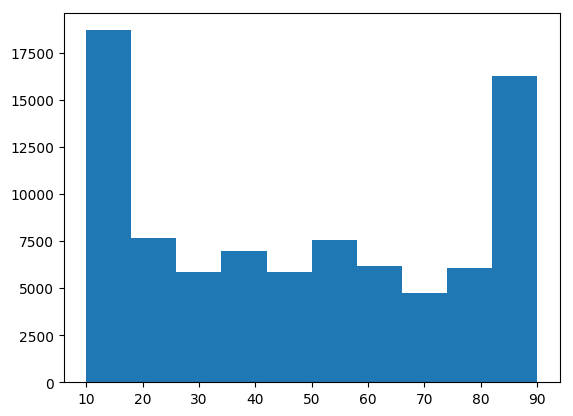

In [171]:
plt.hist(df.azimuth_rf[np.where(np.isnan(df.azimuth_rf)!=1)[0]])

In [123]:
df = pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/unit_table/unit_table_20190903.csv')

In [174]:
AMO=[]
SEP=[]
m_id=[]
sep_start=0
probes = []
for ii, mouseID in enumerate(mouseIDs):
    print(mouseID)
    # 1. load spikes
    basepath = '/Volumes/local1/work_allen/Ephys/resorted/'+mouseID
    if os.path.isfile('/Volumes/local1/work_allen/Ephys/resorted/'+mouseID+'/matrix/flash_all_units.npz'):
        spikes = load_npz(basepath+'/matrix/flash_all_units.npz')
        # add area without layer
        # with the new file, can't load with index_col
        df_old = pd.read_csv(basepath+'/matrix/'+mouseID+'_all_units_meta.csv')
        
        selection = (df.mouse == int(mouseID[5:])) & \
                (df.p_value_rf < 0.05) & \
                (df.time_to_first_spike_fl < 0.1) & \
                (df.area_rf < 2000) & \
                (df.firing_rate_fl > 0.5) & \
                (df.elevation_rf >= -20) & \
                (df.azimuth_rf >= 20) & \
                (df.elevation_rf <= 40) & \
                (df.azimuth_rf <= 80) & \
                (df.snr > 1)
                
        df_new = df_unit[selection]
        df_new = df_new.reset_index().drop(['index'], axis=1)
        
        # select units in matrix satisfy df_new
        idx=[]
        A=[]
        for index, row in df_old.iterrows():
            probe = row['probe_id']
            unit_id = row['unit_id']
            if unit_id in df_new[df_new['probe_description']==probe].local_index_unit.values:
                idx.append(index)
                A.append(df_new[(df_new['probe_description']==probe) & (df_new['local_index_unit']==unit_id)].structure_acronym.values[0])
            
        df_select = df_old.iloc[idx]
        df_select = df_select.reset_index().drop(['index'], axis=1)
        df_select['areas_group']=A
        spikes = spikes[idx, :,:,:]
        assert len(df_select)==spikes.shape[0]

        probenames = df_select.probe_id.unique().astype(str)
        separations = [0]
        #separations[-1]=separations[-1]-1
        for probe in probenames:
            index = np.where(df_select.probe_id==probe)[0]
            separations = np.concatenate([separations, [index[-1]+1]],axis=0)

        ACCG=np.zeros((spikes.shape[0], spikes.shape[-1]))
        for i in range(spikes.shape[0]):
            x = spikes[i,1,:,:]
            tmp = autocorr2D(x)
            ACCG[i,:]=tmp.mean(0)
        
        print(ACCG.shape)
        
        if ii==0:
            AMO=ACCG
            probes = df_select.areas_group
            m_id.append([mouseID]*len(df_select))
        else:
            AMO=np.concatenate([AMO, ACCG], axis=0)
            probes = np.concatenate([probes, df_select.areas_group], axis=0)
            m_id.append([mouseID]*len(df_select))

        separations=separations+sep_start
        SEP.append(separations)
        sep_start=separations[-1]
m_id = [item for sublist in m_id for item in sublist] 

mouse386129
(136, 250)
mouse387858
(112, 250)
mouse388521


KeyboardInterrupt: 

# with old-style preprocessed data

In [ ]:
AMO=[]
SEP=[]
m_id=[]
sep_start=0
probes = []
for ii, mouseID in enumerate(mouseIDs):
    print(mouseID)
    # 1. load spikes
    basepath = '/Volumes/local1/work_allen/Ephys/resorted/'+mouseID
    if os.path.isfile('/Volumes/local1/work_allen/Ephys/resorted/'+mouseID+'/matrix/flash_all_units.npz'):
        spikes = load_npz(basepath+'/matrix/flash_all_units.npz')
        # add area without layer
        # with the new file, can't load with index_col
        df_old = pd.read_csv(basepath+'/matrix/'+mouseID+'_all_units_meta.csv')
        if 'b' in df_old.ccf.unique()[0]:
            df_old['ccf'] = df_old['ccf'].apply(lambda x: x[2:-1])
        #print(df_old.ccf.unique())
        
        df_old['areas_group']=np.zeros(len(df_old))
        for a in areas_all:
            df_old['areas_group'][df_old['ccf'].str.contains(a, case=False, na=False, regex=False)]=a
        # select units in cortex and LP and LGD
        idx=[]
        for probe in df_old.probe_id.unique():
            df_tmp = df_old[(df_old.probe_id==probe) & (df_old.snr>1) & (df_old.qc_amp<0.1)]
            areas = df_tmp.areas_group.unique()
            for a in areas:
                if 'VIS' in str(a) or 'LP' in str(a) or 'LGd' in str(a):
                    idx.append(df_tmp[df_tmp.areas_group==a].index.values)
        idx = [item for sublist in idx for item in sublist]         

        df=df_old.iloc[idx]
        df = df.reset_index().drop(['index'], axis=1)
        spikes = spikes[idx, :, :, :]
        
        FR = df.FR.values
        assert len(df)==spikes.shape[0]

        #constrain by RF on screen
        # load RF fit
        df_rf = pd.read_csv('/Volumes/local1/work_allen/Ephys/processed_data/RF_features/resorted/'+mouseID+'_rf_features.csv', index_col=0)    
        rf_index=[]
        for index, row in df.iterrows():
            probe=row['probe_id']
            unit=row['unit_id']
            df_rf_tmp=df_rf[df_rf.probe_id==probe]
            # RF fit exist
            if unit in df_rf_tmp.unit_id.values:
                pos = df_rf[(df_rf.probe_id==probe) & (df_rf.unit_id==unit)].as_matrix(columns = ('rf_center_x1','rf_center_y1'))
                pos = pos.astype(float)[0]
                # RF center on screen
                if pos[0]>1 and pos[0]<7 and pos[1]>1 and pos[1]<7:
                    rf_index.append(index)
        spikes_new=spikes[rf_index,:,:,:]
        df_new=df.iloc[rf_index]
        df_new = df_new.reset_index().drop(['index'], axis=1)

        probenames = df_new.probe_id.unique().astype(str)
        separations = [0]
        #separations[-1]=separations[-1]-1
        for probe in probenames:
            index = np.where(df_new.probe_id==probe)[0]
            separations = np.concatenate([separations, [index[-1]+1]],axis=0)

        ACCG=np.zeros((spikes_new.shape[0], spikes_new.shape[-1]))
        for i in range(spikes_new.shape[0]):
            x = spikes_new[i,1,:,:]
            tmp = autocorr2D(x)
            ACCG[i,:]=tmp.mean(0)
        
        print(ACCG.shape)
        
        if ii==0:
            AMO=ACCG
            probes = df_new.areas_group
            m_id.append([mouseID]*len(df_new))
        else:
            AMO=np.concatenate([AMO, ACCG], axis=0)
            probes = np.concatenate([probes, df_new.areas_group], axis=0)
            m_id.append([mouseID]*len(df_new))

        separations=separations+sep_start
        SEP.append(separations)
        sep_start=separations[-1]
m_id = [item for sublist in m_id for item in sublist] 

mouse386129
(284, 250)
mouse387858
(184, 250)
mouse388521


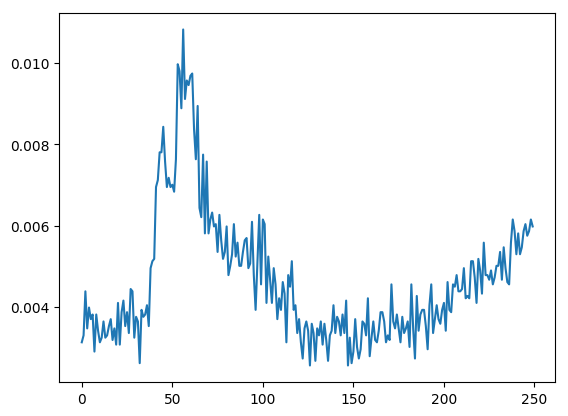

In [150]:
plt.plot(spikes.mean(0).mean(0).mean(0))

In [159]:
a = 0
for probe in np.unique(probes):
    print(probe, len(np.where(probes==probe)[0]))
    a+=len(np.where(probes==probe)[0])
print(a)

('APN', 191)
('CA1', 47)
('CA3', 28)
('DG', 18)
('Eth', 9)
('HPF', 4)
('IGL', 13)
('IntG', 6)
('LD', 10)
('LGd', 258)
('LGv', 40)
('LP', 433)
('LT', 1)
('MB', 16)
('MGd', 2)
('MGm', 8)
('MGv', 5)
('NOT', 58)
('OP', 6)
('PO', 7)
('POL', 16)
('PP', 3)
('PPT', 6)
('PoT', 1)
('ProS', 4)
('SCig', 10)
('SGN', 12)
('SUB', 11)
('TH', 14)
('VIS', 165)
('VISal', 597)
('VISam', 926)
('VISl', 606)
('VISli', 90)
('VISmma', 50)
('VISmmp', 11)
('VISp', 1563)
('VISpm', 557)
('VISrl', 549)
('VL', 1)
('VPM', 4)
('ZI', 3)
('none', 301)
6660


# plot autocorrelation in each area averaged across mice

In [160]:
areas = ('LGd','VISp','VISl','VISrl','LP','VISal','VISpm','VISam')

m = []
for i, probe in enumerate(areas):
    #plt.plot(np.nanmean(AMO[np.where(probes==probe)[0],:], axis=0), c=color_bank[probe])
    m.append(max(np.nanmean(AMO[np.where(probes==probe)[0],:], axis=0)))   


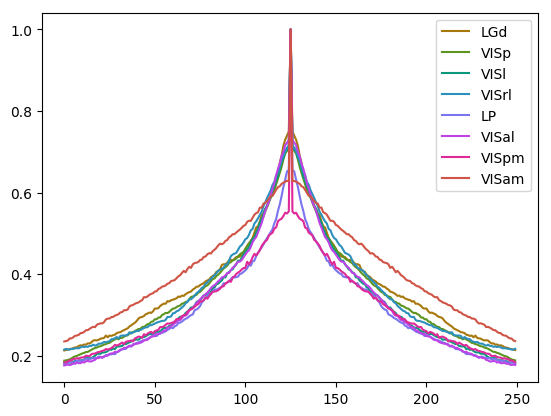

In [161]:
for i, probe in enumerate(areas):
    plt.plot(np.nanmean(AMO[np.where(probes==probe)[0],:], axis=0)/m[i], c=color_bank[probe], label=probe)
plt.legend()
#plt.xlim([500, 1000])

# fit

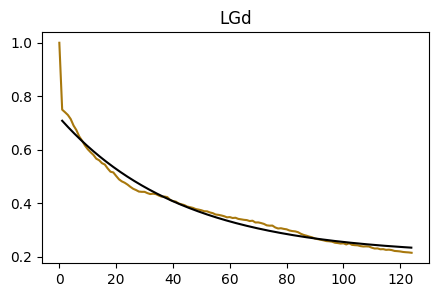

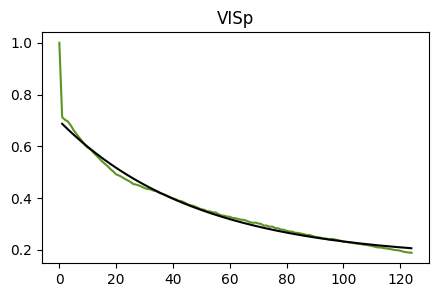

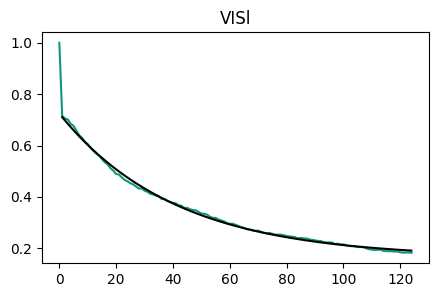

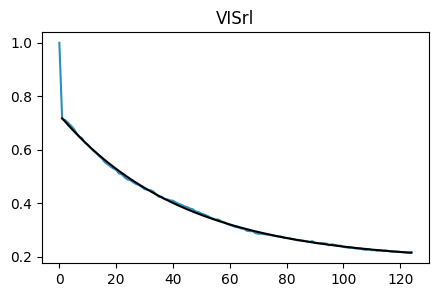

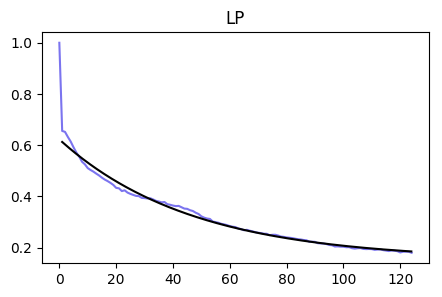

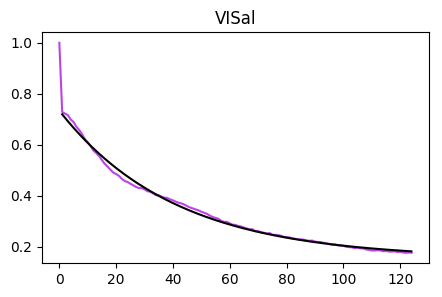

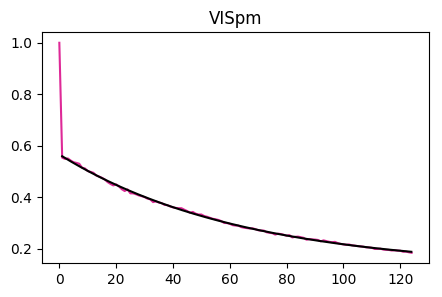

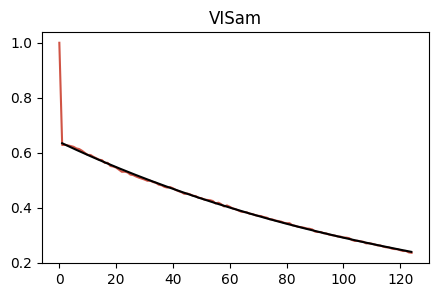

In [154]:
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

intrinsic=[]
FIT=[]
Y=[]

for i, probe in enumerate(areas):
    tmp = np.nanmean(AMO[np.where(probes==probe)[0],125:], axis=0)/m[i]
    
    plt.figure(figsize=(5,3))
    plt.plot(tmp, c=color_bank[probe])

    t = np.arange(len(tmp))[1:]
    y = tmp[1:]
    
    p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.5, 20, 0.1), maxfev = 1000000000)

    a=p[0]
    b=p[1]
    c=p[2]
    fit_y_original = a*np.exp(-1/b*t)+c
    
    xspacing = 0.1
    xt = np.arange(min(t), max(t),xspacing)
    fit_y = a*np.exp(-1/b*xt)+c
    
    #p0=[-4, -1, 1]
    #A, K, C = ef.fit_exp_nonlinear(t, y, p0)
    #fit_y = ef.model_func(t, A, K, C)
    plt.plot(xt, fit_y, 'k-',)
    #plt.errorbar(t, y, np.nanstd(tmp, axis=0)[1:]/np.sqrt(n))
    #plt.plot(np.nanmean(tmp, axis=0)[:20])
    plt.title(probe)
    intrinsic.append([a,b,c])
    FIT.append(fit_y)
    Y.append(y)
    #plt.ylim([0.2, 0.4])
    #plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/intrinsic_timescale/summary_BOb+FCmice_flash_bin25_'+probe+'.pdf')

([0.5152549834720405, 42.72503307341599, 0.2048630458861606], 85.45006614683199)
([0.532142815975526, 48.12253285881636, 0.1655922669097226], 96.24506571763273)
([0.560064081972995, 40.86237950821494, 0.1639754734709788], 81.72475901642989)
([0.5476105605009616, 43.45291897788873, 0.18240308086937768], 86.90583795577746)
([0.4710247109969312, 46.76461769420663, 0.1513661974273196], 93.52923538841326)
([0.578474747817985, 40.708710894316354, 0.1552338624962432], 81.41742178863271)
([0.4427895080198409, 64.48074552901811, 0.12316969188882425], 128.96149105803622)
([0.6665297766241497, 135.16955703459078, -0.027226963641943543], 270.33911406918156)


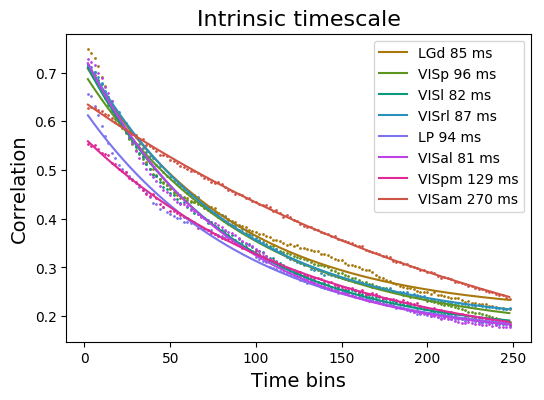

In [155]:
plt.style.use('default')

plt.figure(figsize=(6,4))
for i in range(8):
    probe=areas[i]
    tau = intrinsic[i][1]*2
    plt.scatter(t*2, Y[i], c=color_bank[probe], s=1)
    plt.plot(xt*2, FIT[i],c=color_bank[probe], label=probe+' '+str(int(round(tau)))+' ms')
    print(intrinsic[i], tau)
plt.xlabel('Time bins', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title('Intrinsic timescale', fontsize=16)
#plt.xlim([200,1000])
plt.legend()
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale_summary_BOb+FC_flash_bin25_fitpoints.pdf')

# Calculate decay rate of autocorrelation in each mouse

In [162]:
mouseIDs=np.unique(np.array(m_id))
print(mouseIDs)

['mouse386129' 'mouse387858' 'mouse388521' 'mouse394208' 'mouse403407'
 'mouse404551' 'mouse404553' 'mouse404554' 'mouse404555' 'mouse404568'
 'mouse404569' 'mouse404570' 'mouse404571' 'mouse405751' 'mouse405755'
 'mouse406805' 'mouse406807' 'mouse406808' 'mouse407972' 'mouse408152'
 'mouse410343' 'mouse412791' 'mouse412792' 'mouse412793' 'mouse412794'
 'mouse412799' 'mouse412802' 'mouse412803' 'mouse412804' 'mouse412809'
 'mouse415148' 'mouse415149' 'mouse416356' 'mouse416357' 'mouse417678'
 'mouse418196' 'mouse419112' 'mouse419116' 'mouse419117' 'mouse419118'
 'mouse419119' 'mouse421338' 'mouse421529' 'mouse424445' 'mouse424448'
 'mouse425597' 'mouse425599' 'mouse429857' 'mouse432104' 'mouse432105'
 'mouse434488' 'mouse434494' 'mouse434836' 'mouse437660' 'mouse437661'
 'mouse448503']


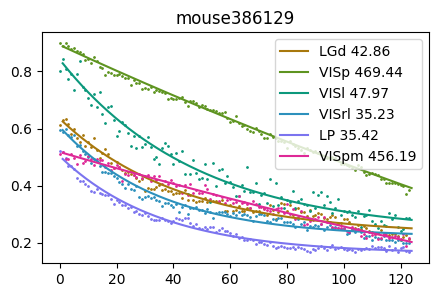

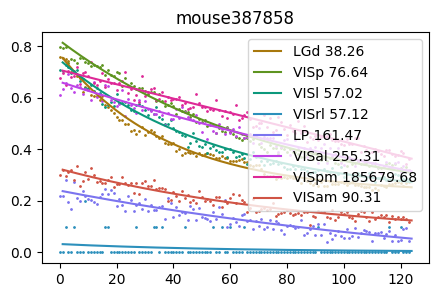

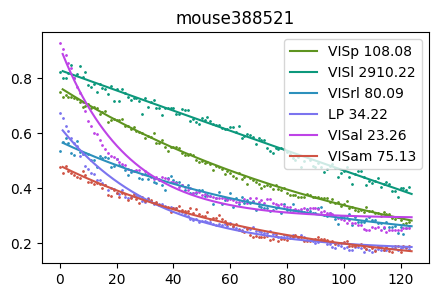

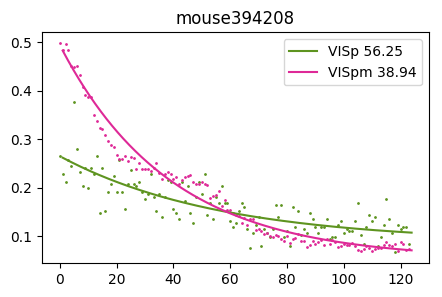

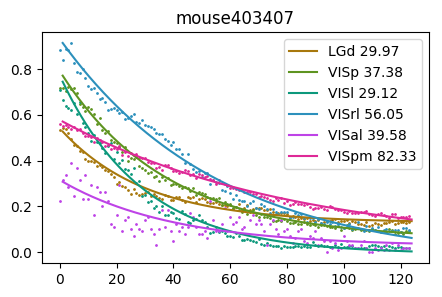

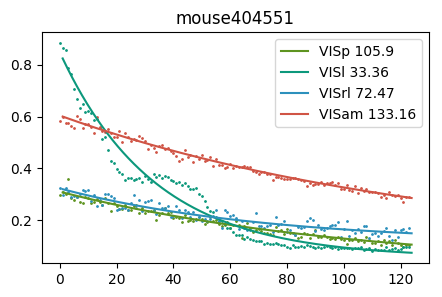

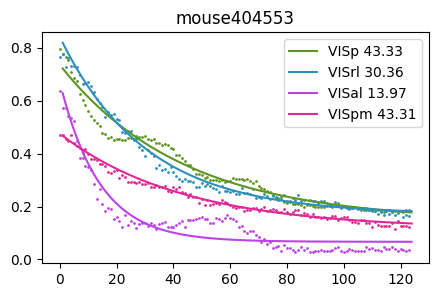

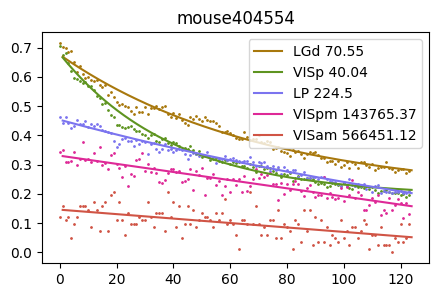

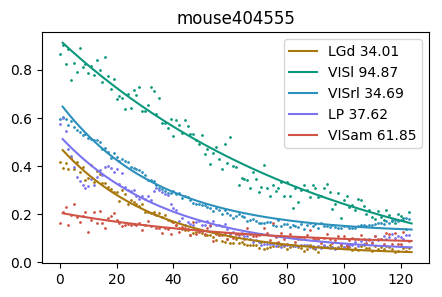

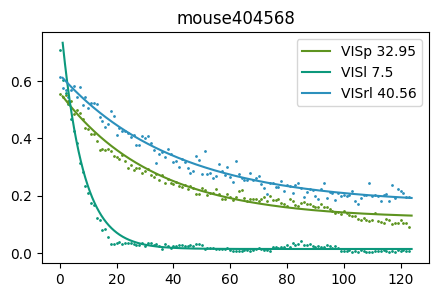

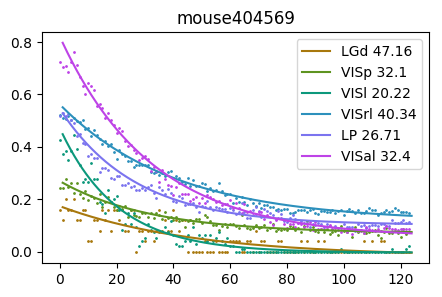

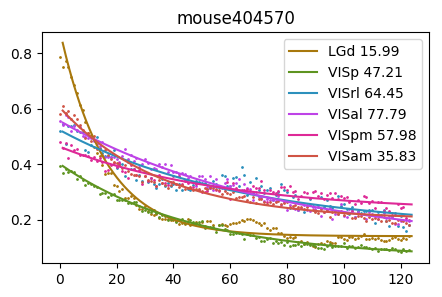

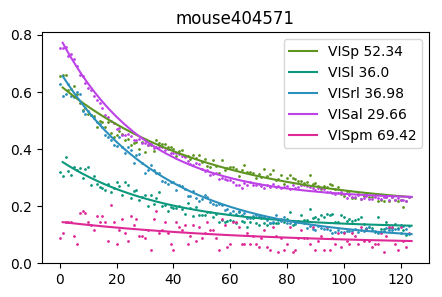

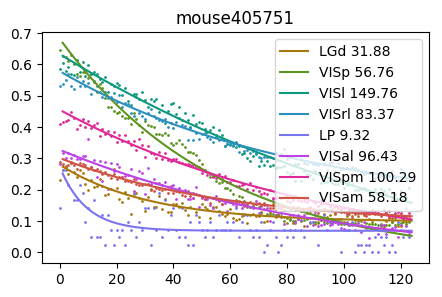

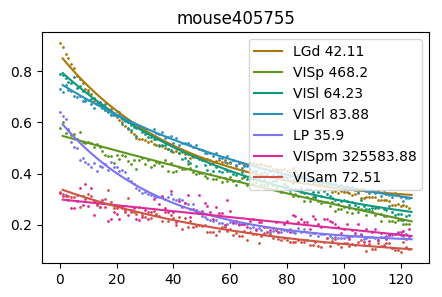

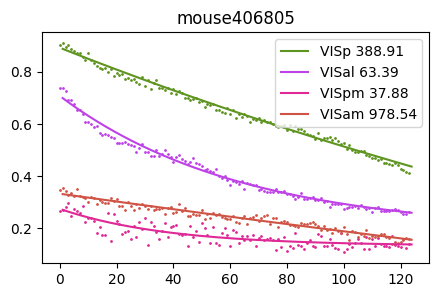

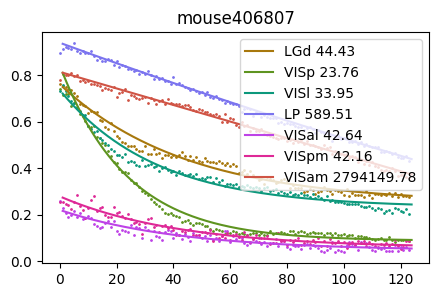

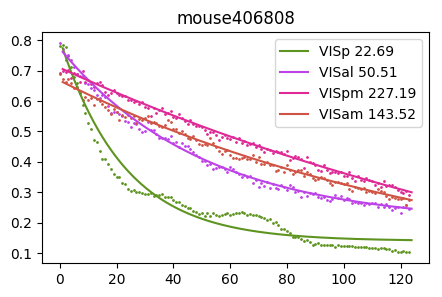

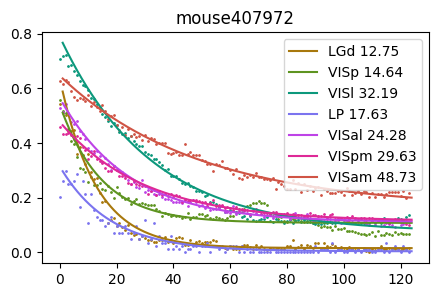

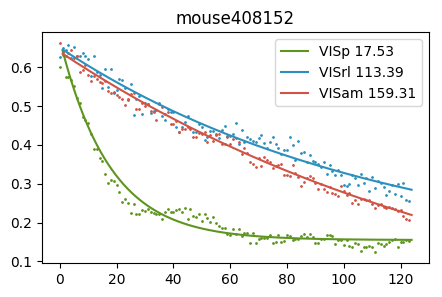

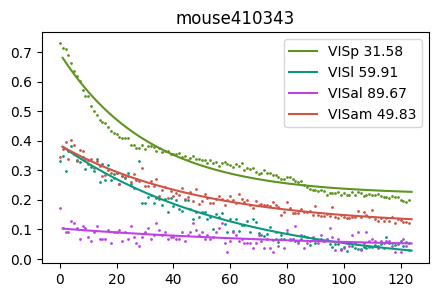

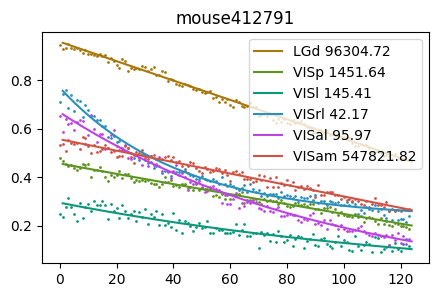

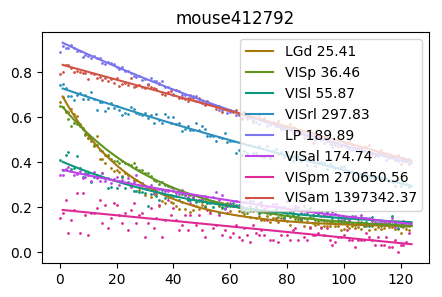

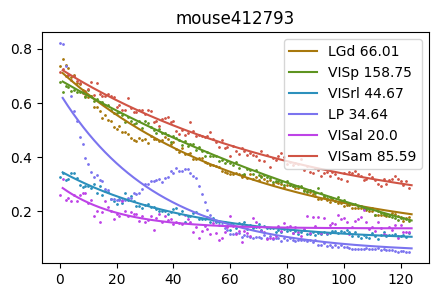

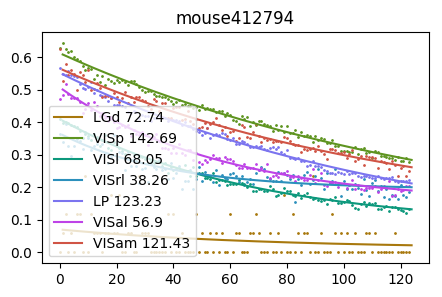

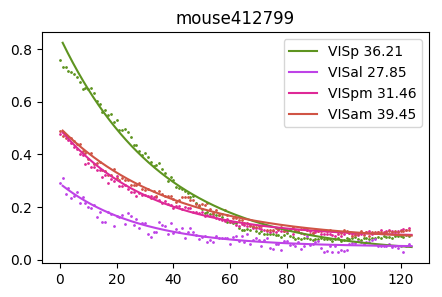

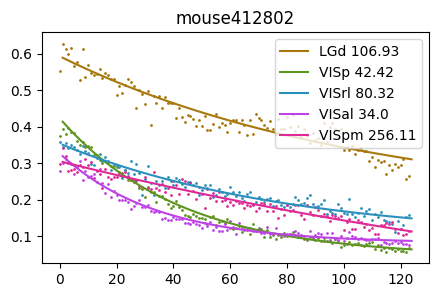

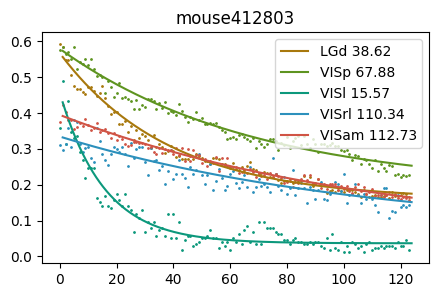

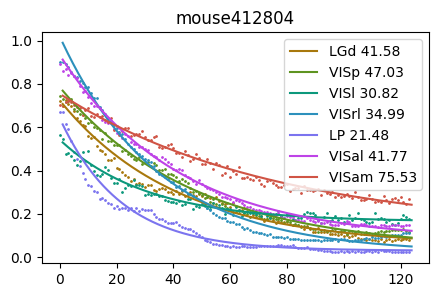

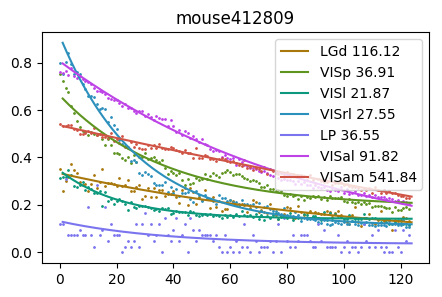

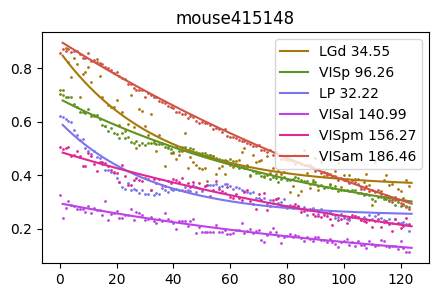

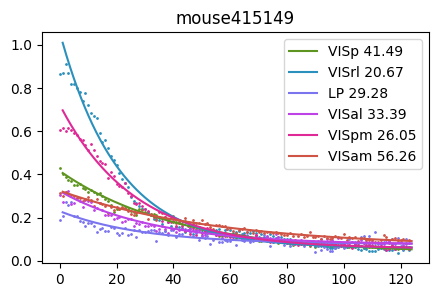

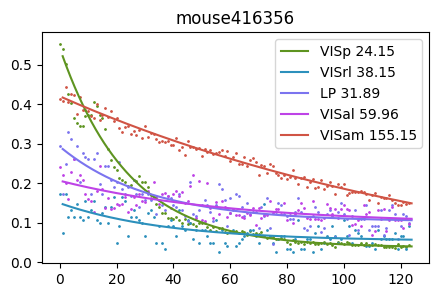

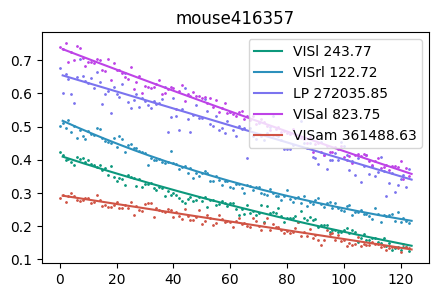

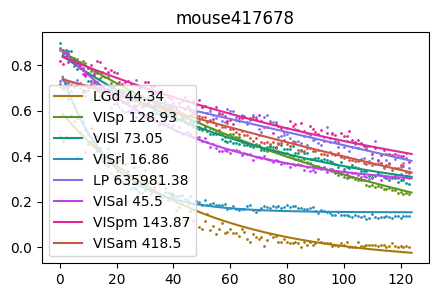

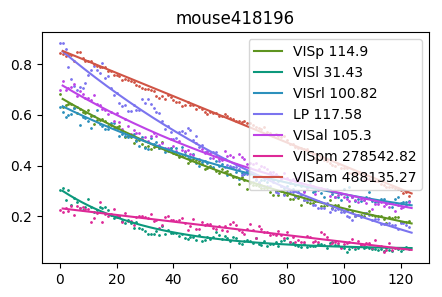

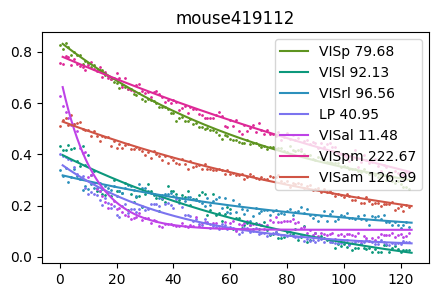

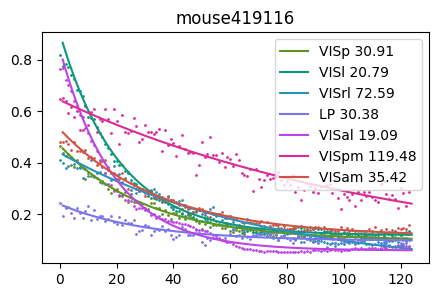

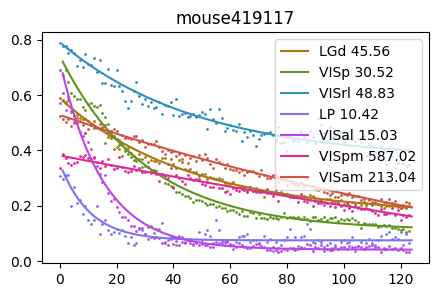

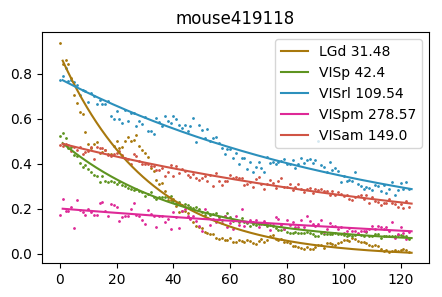

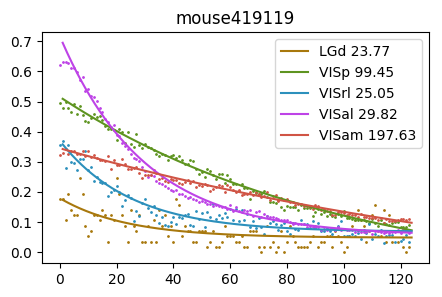

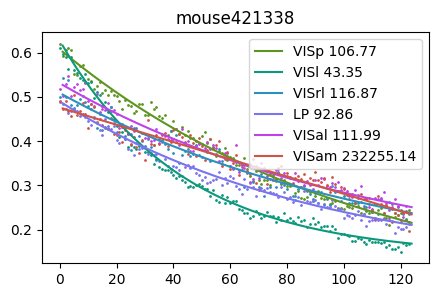

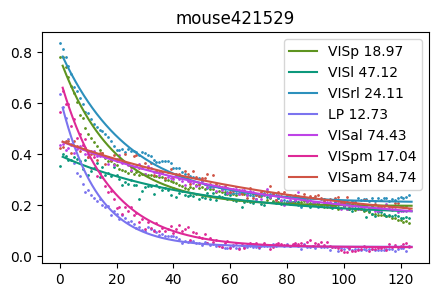

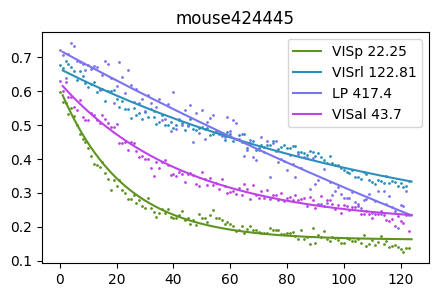

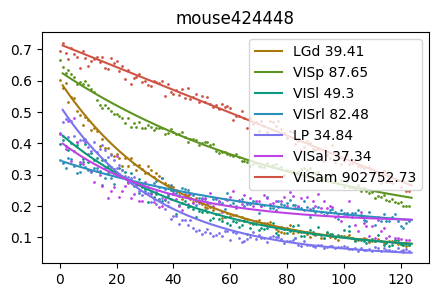

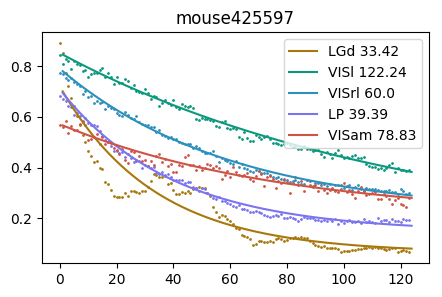

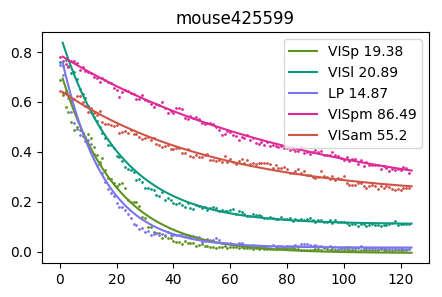

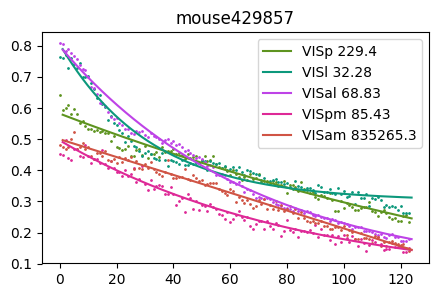

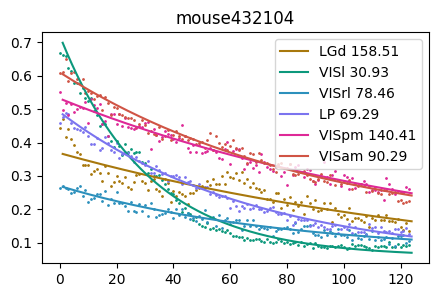

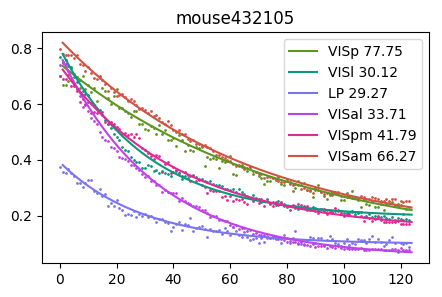

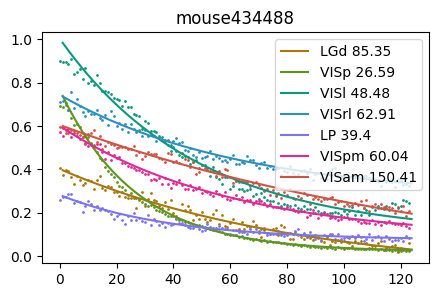

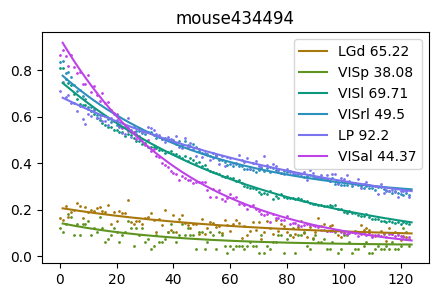

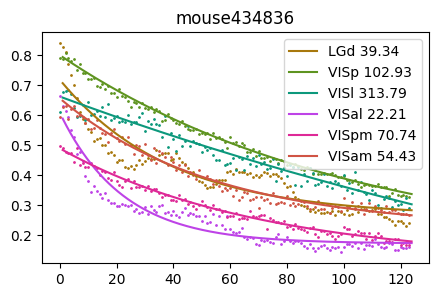

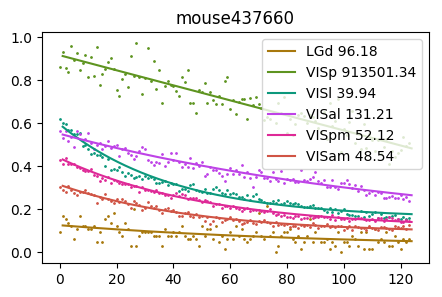

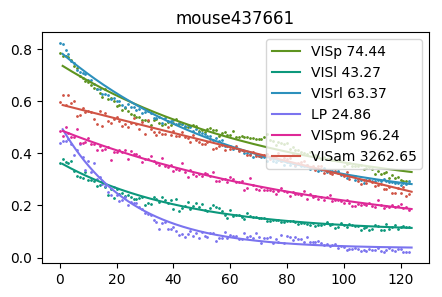

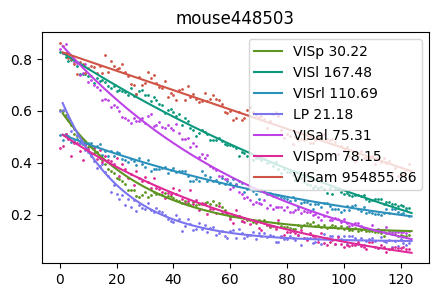

In [163]:
intrinsic_all=[]

for mouse in mouseIDs:
    
    intrinsic=np.NaN*np.zeros((len(areas),3))
    probe_tmp=probes[np.where(np.array(m_id)==mouse)[0]]
    plt.figure(figsize=(5,3))
    for i, probe in enumerate(areas):
        if probe in np.unique(probe_tmp):
            tmp = np.nanmean(AMO[np.where((probes==probe) & (np.array(m_id)==mouse))[0],125:], axis=0)
            if sum(tmp)!=0:
                tmp = tmp/max(tmp)

                plt.scatter(range(len(tmp)-1), tmp[1:], c=color_bank[probe], s=1)

                t = np.arange(len(tmp))[1:]
                y = tmp[1:]

                p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.5, 20, 0.1), maxfev = 1000000000)

                a=p[0]
                b=p[1]
                c=p[2]
                fit_y_original = a*np.exp(-1/b*t)+c
                
                xspacing = 0.1
                xt = np.arange(min(t), max(t),xspacing)
                fit_y = a*np.exp(-1/b*xt)+c

                plt.plot(xt, fit_y, c=color_bank[probe], label=probe+' '+str(round(b,2)))
                plt.title(mouse)
                intrinsic[i,:]=np.array([a,b,c])
    plt.legend()
    intrinsic_all.append(intrinsic)

intrinsic_all=np.array(intrinsic_all)


(0, 300)

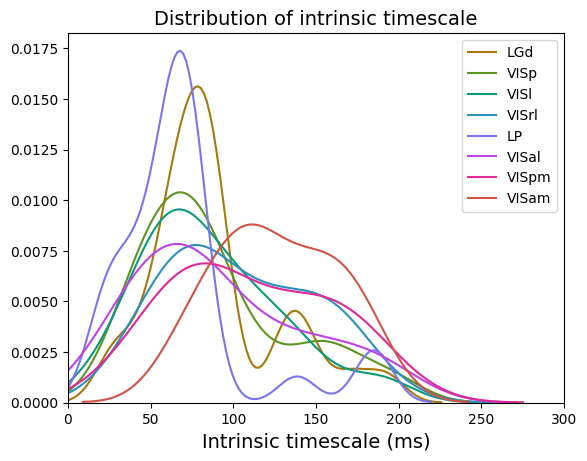

In [164]:
import seaborn as sns
for i, probe in enumerate(areas):
    tmp = intrinsic_all[:,i,1]*2
    tmp[np.where(tmp>200)]=np.NaN
    #plt.hist(tmp[np.where(np.isnan(tmp)!=1)])
    sns.kdeplot(tmp[np.where(np.isnan(tmp)!=1)], shade=False, color = color_bank[probe], label=probe)

plt.title('Distribution of intrinsic timescale', fontsize=14)
plt.xlabel('Intrinsic timescale (ms)', fontsize=14)
plt.xlim([0, 300])
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale/ACCG_distribution.pdf')


# plot mouse summary

88.36603432382793
89.06888440799538
86.33070322879918
104.43001237355791
69.29511681630817
92.12249073793967
110.23075615488796
126.29365918226412


([<matplotlib.axis.XTick at 0x1c33b32550>,
 <a list of 8 Text xticklabel objects>)

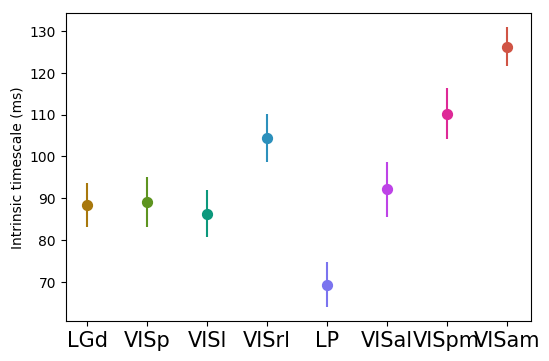

In [165]:
plt.figure(figsize=(6,4))
middle=[]
sds=[]
for i, probe in enumerate(areas):
    tmp = intrinsic_all[:,i,1]*2
    tmp[np.where(tmp>200)]=np.NaN
    
    tau = np.nanmean(tmp)
    middle.append(tau)
    sds.append(np.nanstd(tmp)/np.sqrt(len(tmp)))
    print(tau)
    plt.scatter(i, tau, c=color_bank[probe], s=50)
    plt.errorbar(i, tau, np.nanstd(tmp)/np.sqrt(len(tmp)), fmt='o', c=color_bank[probe])
    
plt.ylabel('Intrinsic timescale (ms)')
#plt.ylim([80,220])
plt.xticks(range(8), areas, fontsize=15)
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/intrinsic_timescale/summary_BOb+FCmice_flash_bin25_time.pdf')
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale_summary_BOb+FC_flash_bin25.pdf')

#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale/ACCG_mean.pdf')


$r_S$ = 0.64; $P_S$ = 0.0856
$r_P$ = 0.54; $P_P$ = 0.1662


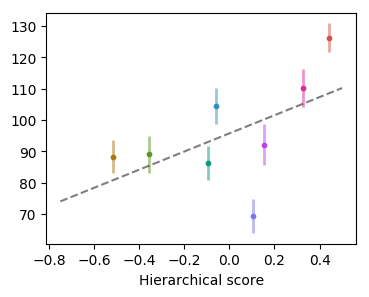

In [166]:
# correlation with hierarchy
from scipy.stats import linregress, pearsonr, spearmanr

x=HS
y = middle
plt.figure(figsize=(4,3))
for k, probe in enumerate(areas):
    plt.plot(x[k], middle[k],'.',color=color_bank[probe])
    plt.errorbar(x[k], middle[k], yerr = sds[k], fmt='.',color=color_bank[probe],alpha=0.5, linewidth=2)

slope,intercept,r,p,std = linregress(x,y)
x2 = np.linspace(-0.75,0.5,10)

plt.plot(x2,x2*slope+intercept,'--k', alpha=0.5)
plt.xlabel('Hierarchical score')

r_s,p_s = spearmanr(x,y)
r_p,p_p = pearsonr(x,y)

text = '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,4)) + '\n' + \
          '$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,4))

print(text)
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale/ACCG_regression.pdf')


# plot example area fit

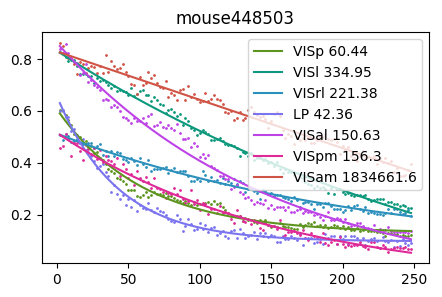

In [167]:

mouse='mouse448503'
    
intrinsic=np.NaN*np.zeros((6,3))
probe_tmp=probes[np.where(np.array(m_id)==mouse)[0]]
plt.figure(figsize=(5,3))
for i, probe in enumerate(areas):
    if probe in np.unique(probe_tmp):
        tmp = np.nanmean(AMO[np.where((probes==probe) & (np.array(m_id)==mouse))[0],125:], axis=0)
        if sum(tmp)!=0:
            tmp = tmp/max(tmp)
            t = np.arange(len(tmp))[1:]*2
            y = tmp[1:]
            
            plt.scatter(t, y, c=color_bank[probe], s=1)

            p, amo = curve_fit(lambda t,a,b,c: a*np.exp(-1/b*t)+c,  t,  y,  p0=(0.5, 20, 0.1), maxfev = 1000000000)

            a=p[0]
            b=p[1]
            c=p[2]
            fit_y_original = a*np.exp(-1/b*t)+c
            
            xspacing = 0.1
            xt = np.arange(min(t), max(t),xspacing)
            fit_y = a*np.exp(-1/b*xt)+c

            plt.plot(xt, fit_y, c=color_bank[probe], label=probe+' '+str(round(b,2)))
            plt.title(mouse)
plt.legend()
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/platform_paper/hierarchy/intrinsic_timescale/ACCG_example_mouse.pdf')

